In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind
import glob

# High-res plots
plt.rcParams["figure.dpi"] = 300
sns.set(style="whitegrid")

# Directory where your CSVs are located
DATA_DIR = "./"


In [2]:
import os
import glob
import pandas as pd

# Read all *_vs_*.csv files into a combined DataFrame
all_files = glob.glob(os.path.join(DATA_DIR, "*_vs_*.csv"))

print(f"Found {len(all_files)} matching files:")
for i, file in enumerate(all_files, 1):
    row_count = len(pd.read_csv(file))
    print(f"{i}. {os.path.basename(file)} ({row_count} rows)")

print("\nProcessing files...")
df_list = []
max_start_id = 0  # Track the highest starting ID

# First pass: Find the maximum starting ID and row counts
print("\nFirst pass - finding maximum starting ID and row counts:")
for file in all_files:
    df = pd.read_csv(file)
    current_start = df['id'].min()
    row_count = len(df)
    print(f"{os.path.basename(file)}: {row_count} rows, starts at ID {current_start}")
    if current_start > max_start_id:
        max_start_id = current_start

print(f"\nHighest starting ID found: {max_start_id}")

# Second pass: Adjust IDs and concatenate
print("\nSecond pass - adjusting IDs:")
total_rows = 0
for file in all_files:
    df = pd.read_csv(file)
    original_start = df['id'].min()
    row_count = len(df)
    total_rows += row_count
    
    # If this file starts before our target, adjust all IDs
    if original_start < max_start_id:
        adjustment = max_start_id - original_start
        df['id'] = df['id'] + adjustment
        print(f"{os.path.basename(file)}: {row_count} rows, adjusted IDs {original_start}+{adjustment} → starts at {df['id'].min()}")
    else:
        print(f"{os.path.basename(file)}: {row_count} rows, no adjustment needed (starts at {original_start})")
    
    df["source_file"] = os.path.basename(file)
    df_list.append(df)

all_results = pd.concat(df_list, ignore_index=False)  # Keep original indices
all_results = all_results.sort_values('id')  # Sort by the adjusted IDs

print(f"\nFinal results:")
print(f"Total rows loaded: {len(all_results)} (sum verification: {total_rows})")
print(f"All IDs now start from {all_results['id'].min()}")
print("\nFirst few rows:")
all_results.head()

Found 21 matching files:
1. qwen3-0.6b_vs_llama4-400b.csv (612 rows)
2. qwen3-latest_vs_gemma3-27b.csv (612 rows)
3. qwen3-0.6b_vs_gemma3-27b.csv (612 rows)
4. gemma3-27b_vs_mistral-small3.1-latest.csv (612 rows)
5. qwen2.5-latest_vs_mistral-small3.1-latest.csv (612 rows)
6. qwen3-latest_vs_qwen2.5-latest.csv (612 rows)
7. qwen3-latest_vs_qwen3-0.6b.csv (612 rows)
8. deepseek-r1-70b-alt_vs_mistral-small3.1-latest.csv (612 rows)
9. deepseek-r1-70b-alt_vs_gemma3-27b.csv (612 rows)
10. qwen3-latest_vs_deepseek-r1-70b-alt.csv (612 rows)
11. qwen3-latest_vs_mistral-small3.1-latest.csv (612 rows)
12. qwen2.5-latest_vs_gemma3-27b.csv (612 rows)
13. qwen3-latest_vs_llama4-400b.csv (612 rows)
14. qwen3-0.6b_vs_qwen2.5-latest.csv (612 rows)
15. deepseek-r1-70b-alt_vs_llama4-400b.csv (612 rows)
16. qwen3-0.6b_vs_deepseek-r1-70b-alt.csv (612 rows)
17. llama4-400b_vs_gemma3-27b.csv (612 rows)
18. qwen3-0.6b_vs_mistral-small3.1-latest.csv (612 rows)
19. llama4-400b_vs_mistral-small3.1-latest.csv (61

,id,condition,model_a,model_b,response_a,response_b,verdict,source_file
0,97,chat_only,qwen3-0.6b,llama4-400b,"<think>\nOkay, let's see. The user is asking m...",ERROR,A,qwen3-0.6b_vs_llama4-400b.csv
1,97,persona_only,qwen3-0.6b,qwen2.5-latest,"<think>\nOkay, the user mentioned ""no content,...",你好！看起来你没有提供具体内容，我该如何帮助你呢？你可以问我问题、讨论某个话题或者请求一些信...,A,qwen3-0.6b_vs_qwen2.5-latest.csv
2,97,persona_plus_chat,qwen3-latest,gemma3-27b,"<think>\nOkay, let's break this down. The user...",This conversation is... concerning. It appears...,B,qwen3-latest_vs_gemma3-27b.csv
2,97,persona_plus_chat,deepseek-r1-70b-alt,llama4-400b,"<think>\nOkay, so I'm looking at this conversa...",ERROR,B,deepseek-r1-70b-alt_vs_llama4-400b.csv
0,97,chat_only,deepseek-r1-70b-alt,llama4-400b,"<think>\nOkay, so I'm trying to figure out how...",ERROR,A,deepseek-r1-70b-alt_vs_llama4-400b.csv


In [3]:
import os
import glob
import pandas as pd
from collections import defaultdict

# Read all *_vs_*.csv files into a combined DataFrame
all_files = glob.glob(os.path.join(DATA_DIR, "*_vs_*.csv"))
df_list = []
max_start_id = 0  # Track the highest starting ID
model_counts = defaultdict(int)  # Track model appearance counts

# First pass: Find max ID and count model appearances
for file in all_files:
    df = pd.read_csv(file)
    current_start = df['id'].min()
    if current_start > max_start_id:
        max_start_id = current_start
    
    # Count model appearances in both columns
    for model in df['model_a']:
        model_counts[model] += 1
    for model in df['model_b']:
        model_counts[model] += 1

# Second pass: Adjust IDs and concatenate
for file in all_files:
    df = pd.read_csv(file)
    current_start = df['id'].min()
    
    if current_start < max_start_id:
        adjustment = max_start_id - current_start
        df['id'] = df['id'] + adjustment
    
    df["source_file"] = os.path.basename(file)
    df_list.append(df)

all_results = pd.concat(df_list, ignore_index=False)
all_results = all_results.sort_values('id')

# Convert model counts to DataFrame and sort
model_stats = pd.DataFrame.from_dict(model_counts, orient='index', columns=['Total Appearances'])
model_stats = model_stats.sort_values('Total Appearances', ascending=False)

# Print statistics
print(f"Loaded {len(all_results)} pairwise comparison rows.")
print(f"All IDs now start from {all_results['id'].min()}")
print(f"\nFound {len(model_counts)} unique models with appearance counts:")
print(model_stats.to_string())

# Show most common model pairs
print("\nMost frequent model pairs:")
pair_counts = all_results.groupby(['model_a', 'model_b']).size()
print(pair_counts.sort_values(ascending=False).head(10).to_string())

all_results.head()

Loaded 12852 pairwise comparison rows.
All IDs now start from 97

Found 7 unique models with appearance counts:
                         Total Appearances
qwen3-0.6b                            3672
llama4-400b                           3672
qwen3-latest                          3672
gemma3-27b                            3672
mistral-small3.1-latest               3672
qwen2.5-latest                        3672
deepseek-r1-70b-alt                   3672

Most frequent model pairs:
model_a              model_b                
deepseek-r1-70b-alt  gemma3-27b                 612
                     llama4-400b                612
                     mistral-small3.1-latest    612
                     qwen2.5-latest             612
gemma3-27b           mistral-small3.1-latest    612
llama4-400b          gemma3-27b                 612
                     mistral-small3.1-latest    612
                     qwen2.5-latest             612
qwen2.5-latest       gemma3-27b                 612
   

,id,condition,model_a,model_b,response_a,response_b,verdict,source_file
0,97,chat_only,qwen3-0.6b,llama4-400b,"<think>\nOkay, let's see. The user is asking m...",ERROR,A,qwen3-0.6b_vs_llama4-400b.csv
1,97,persona_only,qwen3-0.6b,qwen2.5-latest,"<think>\nOkay, the user mentioned ""no content,...",你好！看起来你没有提供具体内容，我该如何帮助你呢？你可以问我问题、讨论某个话题或者请求一些信...,A,qwen3-0.6b_vs_qwen2.5-latest.csv
2,97,persona_plus_chat,qwen3-latest,gemma3-27b,"<think>\nOkay, let's break this down. The user...",This conversation is... concerning. It appears...,B,qwen3-latest_vs_gemma3-27b.csv
2,97,persona_plus_chat,deepseek-r1-70b-alt,llama4-400b,"<think>\nOkay, so I'm looking at this conversa...",ERROR,B,deepseek-r1-70b-alt_vs_llama4-400b.csv
0,97,chat_only,deepseek-r1-70b-alt,llama4-400b,"<think>\nOkay, so I'm trying to figure out how...",ERROR,A,deepseek-r1-70b-alt_vs_llama4-400b.csv


In [4]:
# Read all *_vs_*.csv files into a combined DataFrame
all_files = glob.glob(os.path.join(DATA_DIR, "*_vs_*.csv"))
df_list = []
max_start_id = 0  # Track the highest starting ID

# First pass: Find the maximum starting ID
for file in all_files:
    df = pd.read_csv(file)
    current_start = df['id'].min()
    if current_start > max_start_id:
        max_start_id = current_start

# Second pass: Adjust IDs and concatenate
for file in all_files:
    df = pd.read_csv(file)
    current_start = df['id'].min()
    
    # If this file starts before our target, adjust all IDs
    if current_start < max_start_id:
        adjustment = max_start_id - current_start
        df['id'] = df['id'] + adjustment
    
    df["source_file"] = os.path.basename(file)
    df_list.append(df)

all_results = pd.concat(df_list, ignore_index=False)  # Keep original indices
all_results = all_results.sort_values('id')  # Sort by the adjusted IDs

print(f"Loaded {len(all_results)} pairwise comparison rows.")
print(f"All IDs now start from {all_results['id'].min()}")
all_results.head()

Loaded 12852 pairwise comparison rows.
All IDs now start from 97


,id,condition,model_a,model_b,response_a,response_b,verdict,source_file
0,97,chat_only,qwen3-0.6b,llama4-400b,"<think>\nOkay, let's see. The user is asking m...",ERROR,A,qwen3-0.6b_vs_llama4-400b.csv
1,97,persona_only,qwen3-0.6b,qwen2.5-latest,"<think>\nOkay, the user mentioned ""no content,...",你好！看起来你没有提供具体内容，我该如何帮助你呢？你可以问我问题、讨论某个话题或者请求一些信...,A,qwen3-0.6b_vs_qwen2.5-latest.csv
2,97,persona_plus_chat,qwen3-latest,gemma3-27b,"<think>\nOkay, let's break this down. The user...",This conversation is... concerning. It appears...,B,qwen3-latest_vs_gemma3-27b.csv
2,97,persona_plus_chat,deepseek-r1-70b-alt,llama4-400b,"<think>\nOkay, so I'm looking at this conversa...",ERROR,B,deepseek-r1-70b-alt_vs_llama4-400b.csv
0,97,chat_only,deepseek-r1-70b-alt,llama4-400b,"<think>\nOkay, so I'm trying to figure out how...",ERROR,A,deepseek-r1-70b-alt_vs_llama4-400b.csv


In [5]:
# Initialize win matrix
models = sorted(set(all_results['model_a']).union(set(all_results['model_b'])))
win_matrix = pd.DataFrame(0, index=models, columns=models)

# Tally wins
for _, row in all_results.iterrows():
    verdict = row['verdict']
    a, b = row['model_a'], row['model_b']
    if verdict == "A":
        win_matrix.loc[a, b] += 1
    elif verdict == "B":
        win_matrix.loc[b, a] += 1

win_matrix


,deepseek-r1-70b-alt,gemma3-27b,llama4-400b,mistral-small3.1-latest,qwen2.5-latest,qwen3-0.6b,qwen3-latest
deepseek-r1-70b-alt,0,336,444,410,397,264,199
gemma3-27b,246,0,280,380,251,320,223
llama4-400b,159,320,0,363,331,213,154
mistral-small3.1-latest,186,210,239,0,206,260,165
qwen2.5-latest,200,339,270,390,0,267,189
qwen3-0.6b,337,279,379,333,336,0,164
qwen3-latest,378,357,446,429,414,432,0


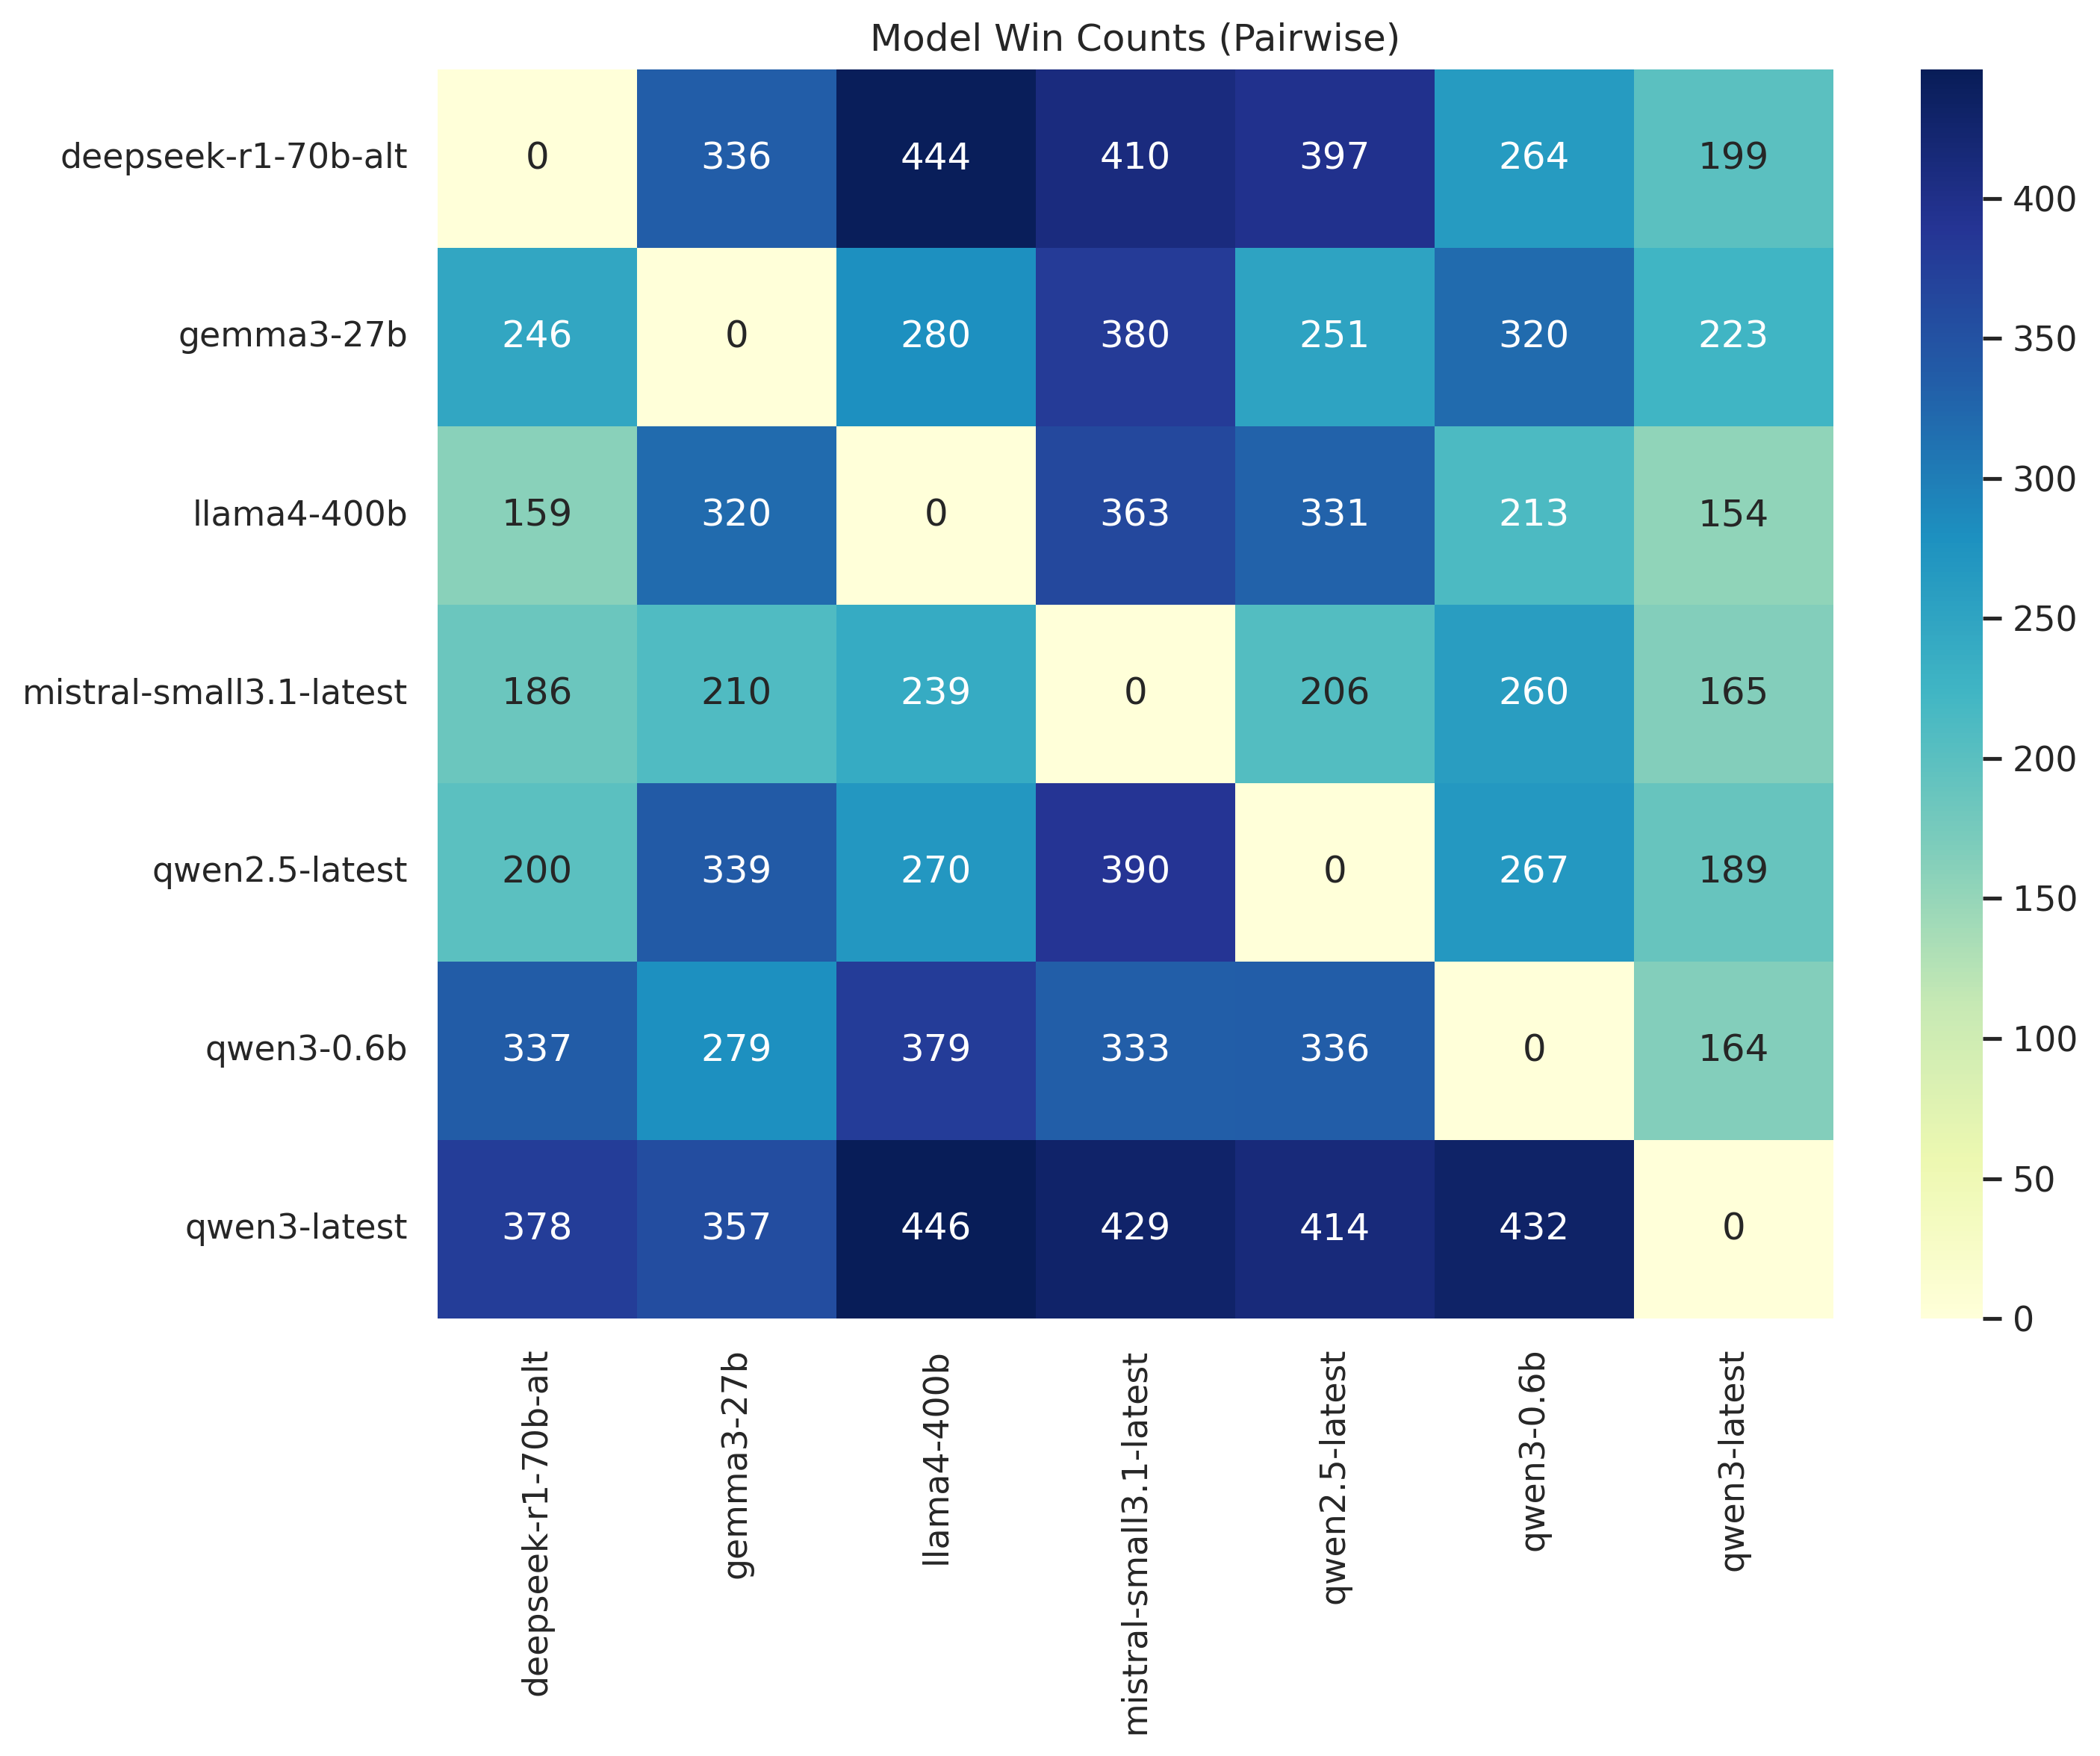

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(win_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Model Win Counts (Pairwise)")
plt.tight_layout()
plt.savefig("win_matrix_heatmap.png", dpi=300)
plt.show()


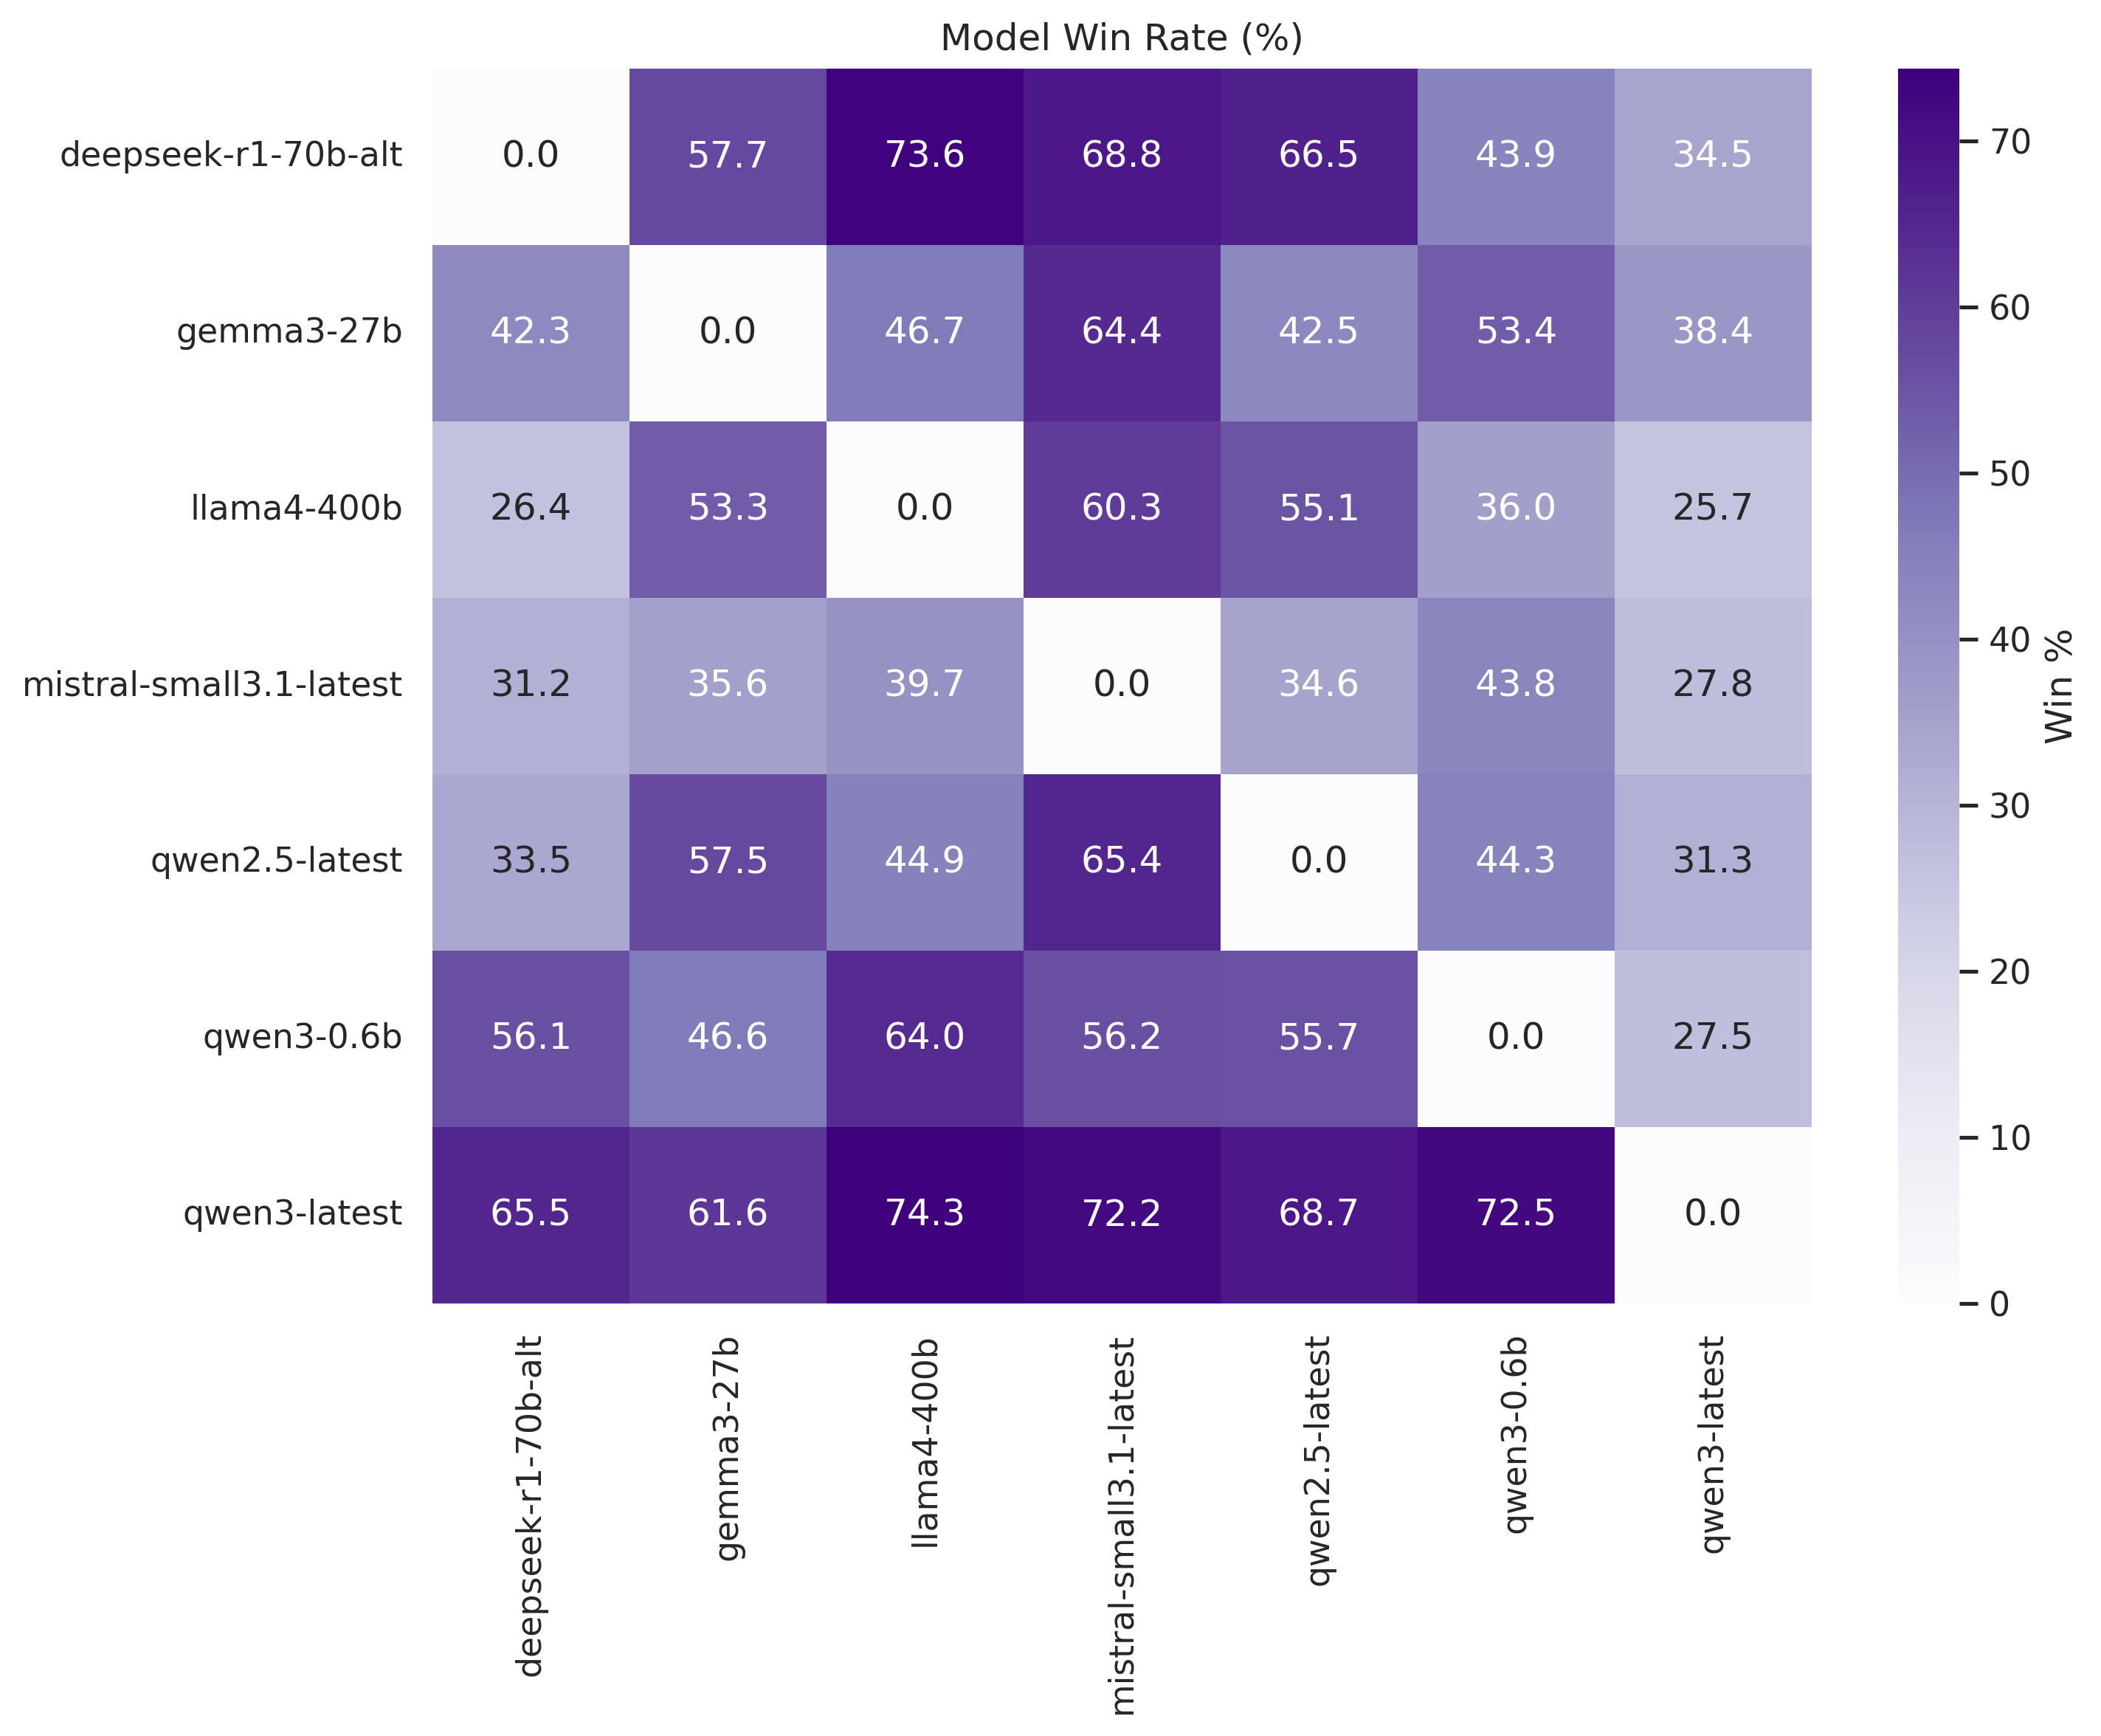

In [7]:
total_matches = win_matrix + win_matrix.T
win_percent = (win_matrix.div(total_matches.where(total_matches > 0), axis=1) * 100).fillna(0)

plt.figure(figsize=(10, 8))
sns.heatmap(win_percent, annot=True, fmt=".1f", cmap="Purples", cbar_kws={"label": "Win %"})
plt.title("Model Win Rate (%)")
plt.tight_layout()
plt.savefig("win_percent_heatmap.png", dpi=300)
plt.show()


In [8]:
# Initialize summary dictionary
summary = {}

# Get all unique models
models = sorted(set(all_results['model_a']).union(set(all_results['model_b'])))

# Calculate statistics for each model
for model in models:
    wins = ((all_results['verdict'] == "A") & (all_results['model_a'] == model)).sum()
    wins += ((all_results['verdict'] == "B") & (all_results['model_b'] == model)).sum()
    
    losses = ((all_results['verdict'] == "B") & (all_results['model_a'] == model)).sum()
    losses += ((all_results['verdict'] == "A") & (all_results['model_b'] == model)).sum()
    
    ties = ((all_results['verdict'] == "Tie") & ((all_results['model_a'] == model) | (all_results['model_b'] == model))).sum()
    
    unknown = ((all_results['verdict'] == "unknown") & ((all_results['model_a'] == model) | (all_results['model_b'] == model))).sum()
    
    total = wins + losses + ties + unknown
    
    summary[model] = {
        "Wins": wins,
        "Losses": losses, 
        "Ties": ties,
        "Unknown": unknown,
        "Total": total
    }

# Convert to DataFrame and sort
summary_df = pd.DataFrame(summary).T.sort_values("Wins", ascending=False)

# Add a totals row
summary_df.loc['Total'] = summary_df.sum()

# Format the display
styled_df = (summary_df
             .style
             .set_caption("Model Performance Summary")
             .format("{:.0f}")
             .highlight_max(subset=["Wins"], color='lightgreen')
             .highlight_min(subset=["Wins"], color='#ffcccb')
             .set_properties(**{'text-align': 'center'}))

styled_df

,Wins,Losses,Ties,Unknown,Total
qwen3-latest,2456,1094,122,0,3672
deepseek-r1-70b-alt,2050,1506,116,0,3672
qwen3-0.6b,1828,1756,88,0,3672
gemma3-27b,1700,1841,131,0,3672
qwen2.5-latest,1655,1935,82,0,3672
llama4-400b,1540,2058,74,0,3672
mistral-small3.1-latest,1266,2305,101,0,3672
Total,12495,12495,714,0,25704


In [9]:
summary = {}

for model in models:
    wins = ((all_results['verdict'] == "A") & (all_results['model_a'] == model)).sum()
    wins += ((all_results['verdict'] == "B") & (all_results['model_b'] == model)).sum()
    losses = ((all_results['verdict'] == "B") & (all_results['model_a'] == model)).sum()
    losses += ((all_results['verdict'] == "A") & (all_results['model_b'] == model)).sum()
    ties = ((all_results['verdict'] == "Tie") & ((all_results['model_a'] == model) | (all_results['model_b'] == model))).sum()
    summary[model] = {"Wins": wins, "Losses": losses, "Ties": ties}

summary_df = pd.DataFrame(summary).T.sort_values("Wins", ascending=False)
summary_df.style.set_caption("Model Overall Performance Summary")


,Wins,Losses,Ties
qwen3-latest,2456,1094,122
deepseek-r1-70b-alt,2050,1506,116
qwen3-0.6b,1828,1756,88
gemma3-27b,1700,1841,131
qwen2.5-latest,1655,1935,82
llama4-400b,1540,2058,74
mistral-small3.1-latest,1266,2305,101


/tmp/ipykernel_110326/718992512.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_df.index, y=summary_df["Wins"], palette="viridis")


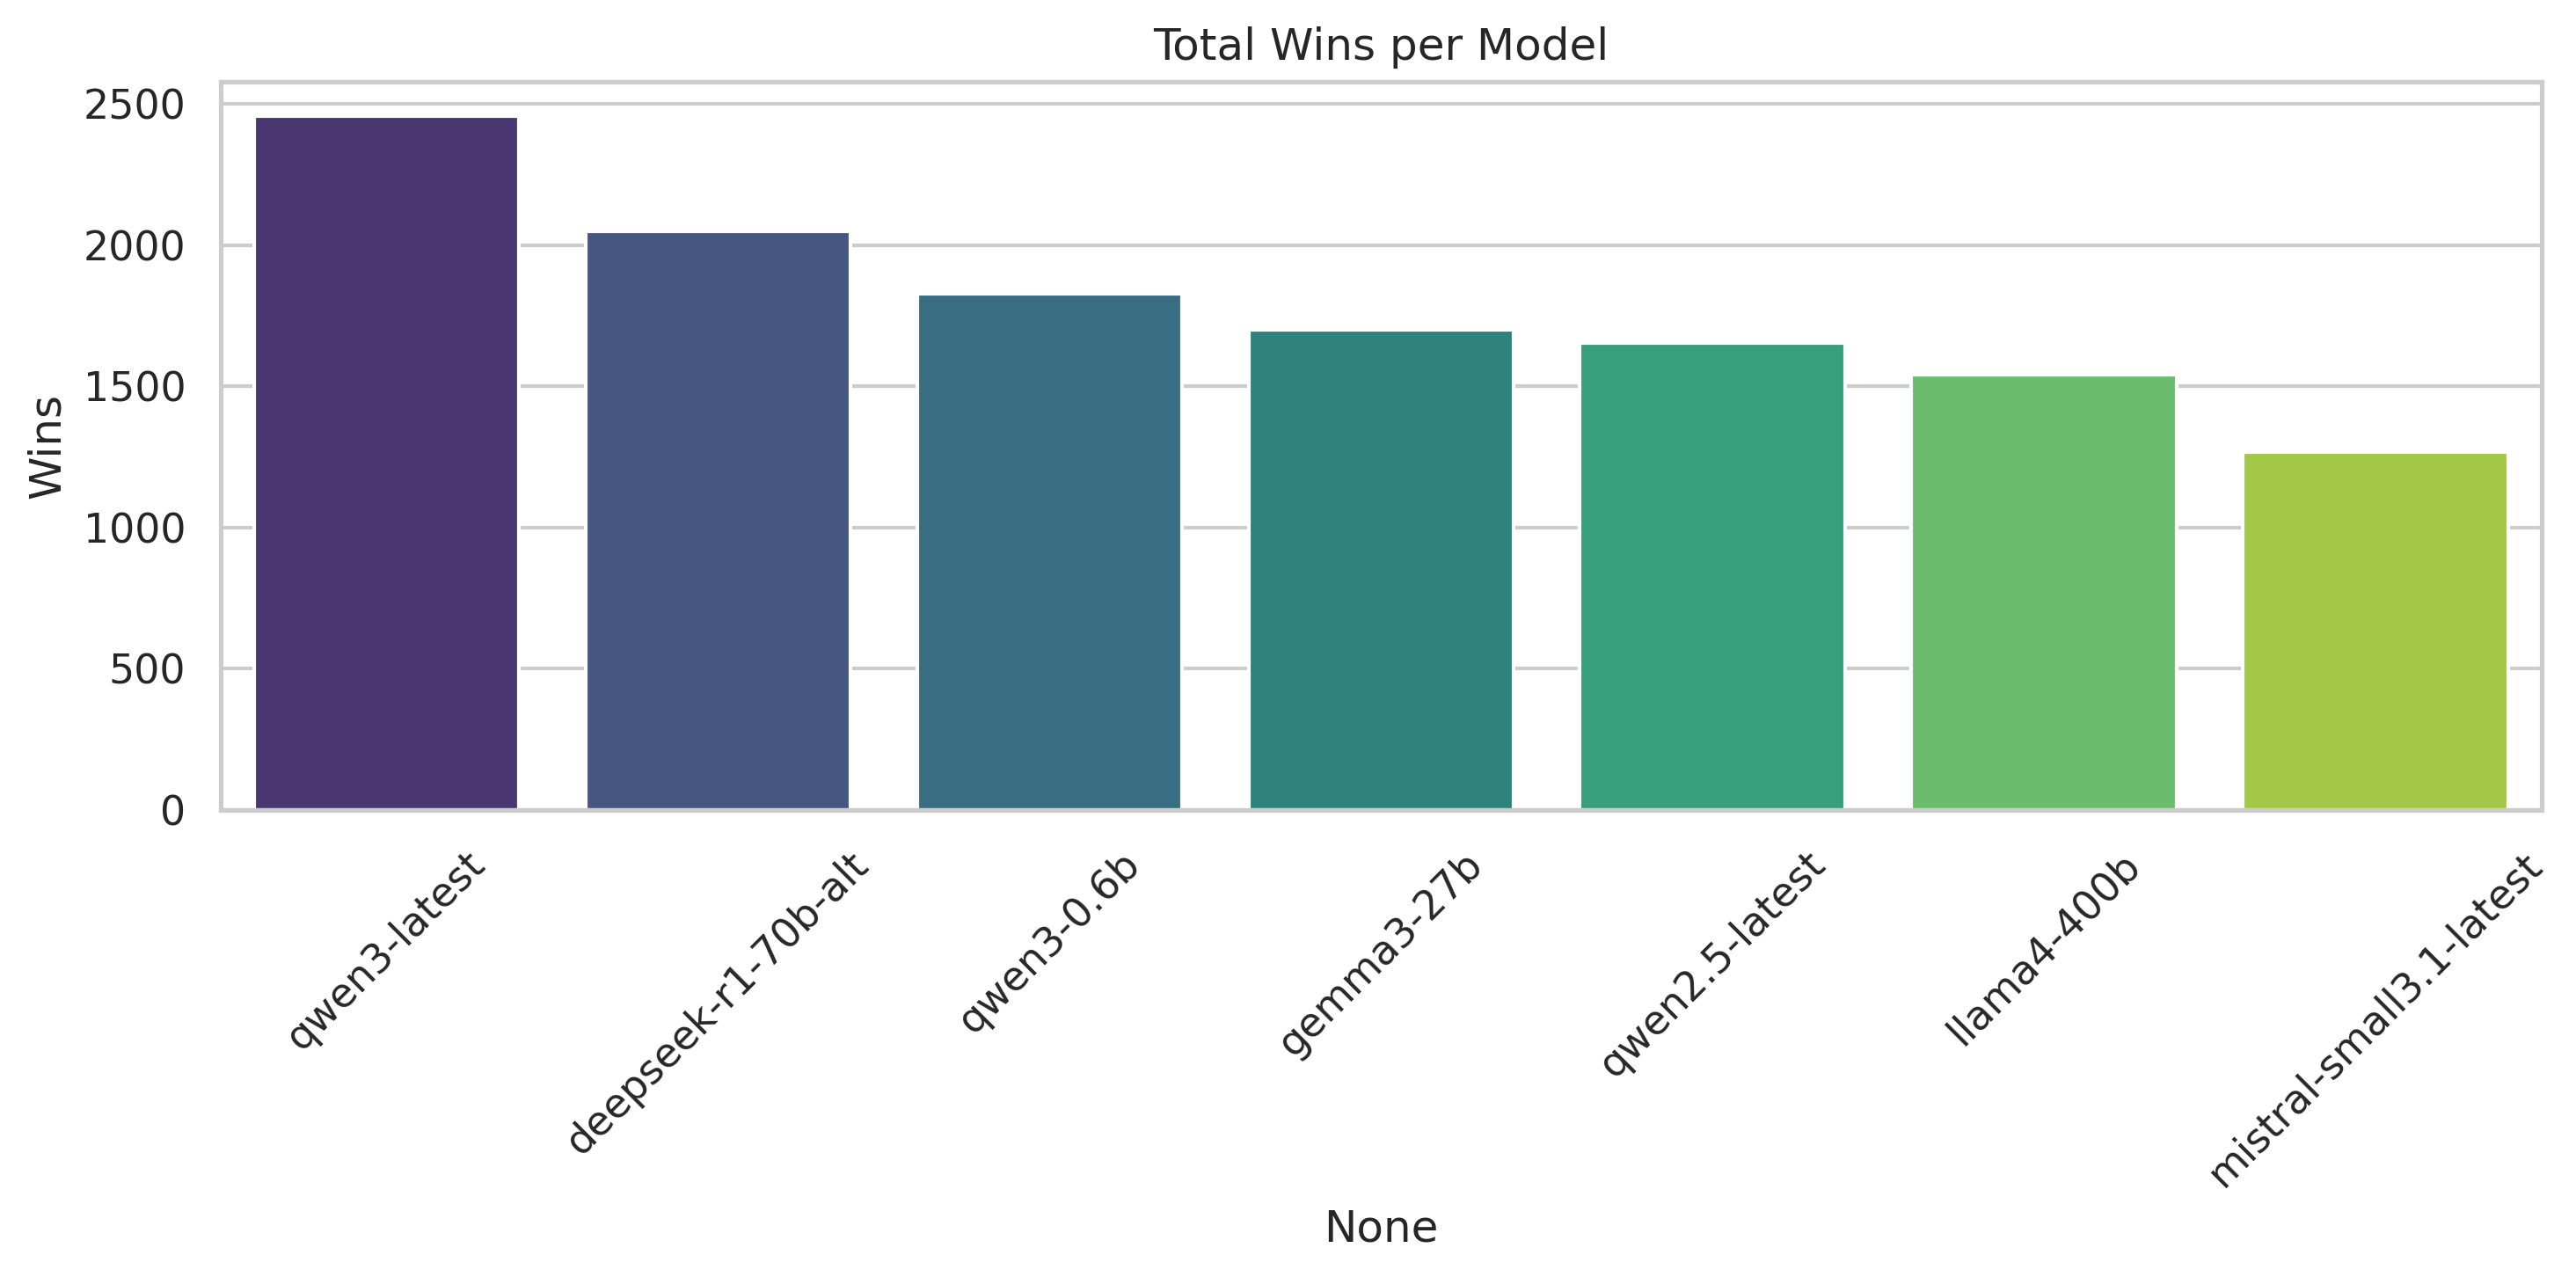

In [10]:
plt.figure(figsize=(10, 5))
sns.barplot(x=summary_df.index, y=summary_df["Wins"], palette="viridis")
plt.title("Total Wins per Model")
plt.ylabel("Wins")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("total_wins_barplot.png", dpi=300)
plt.show()


/tmp/ipykernel_110326/1576642247.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_df.index, y="win_rate", data=summary_df, palette="viridis")


ModuleNotFoundError: No module named 'ace_tools'

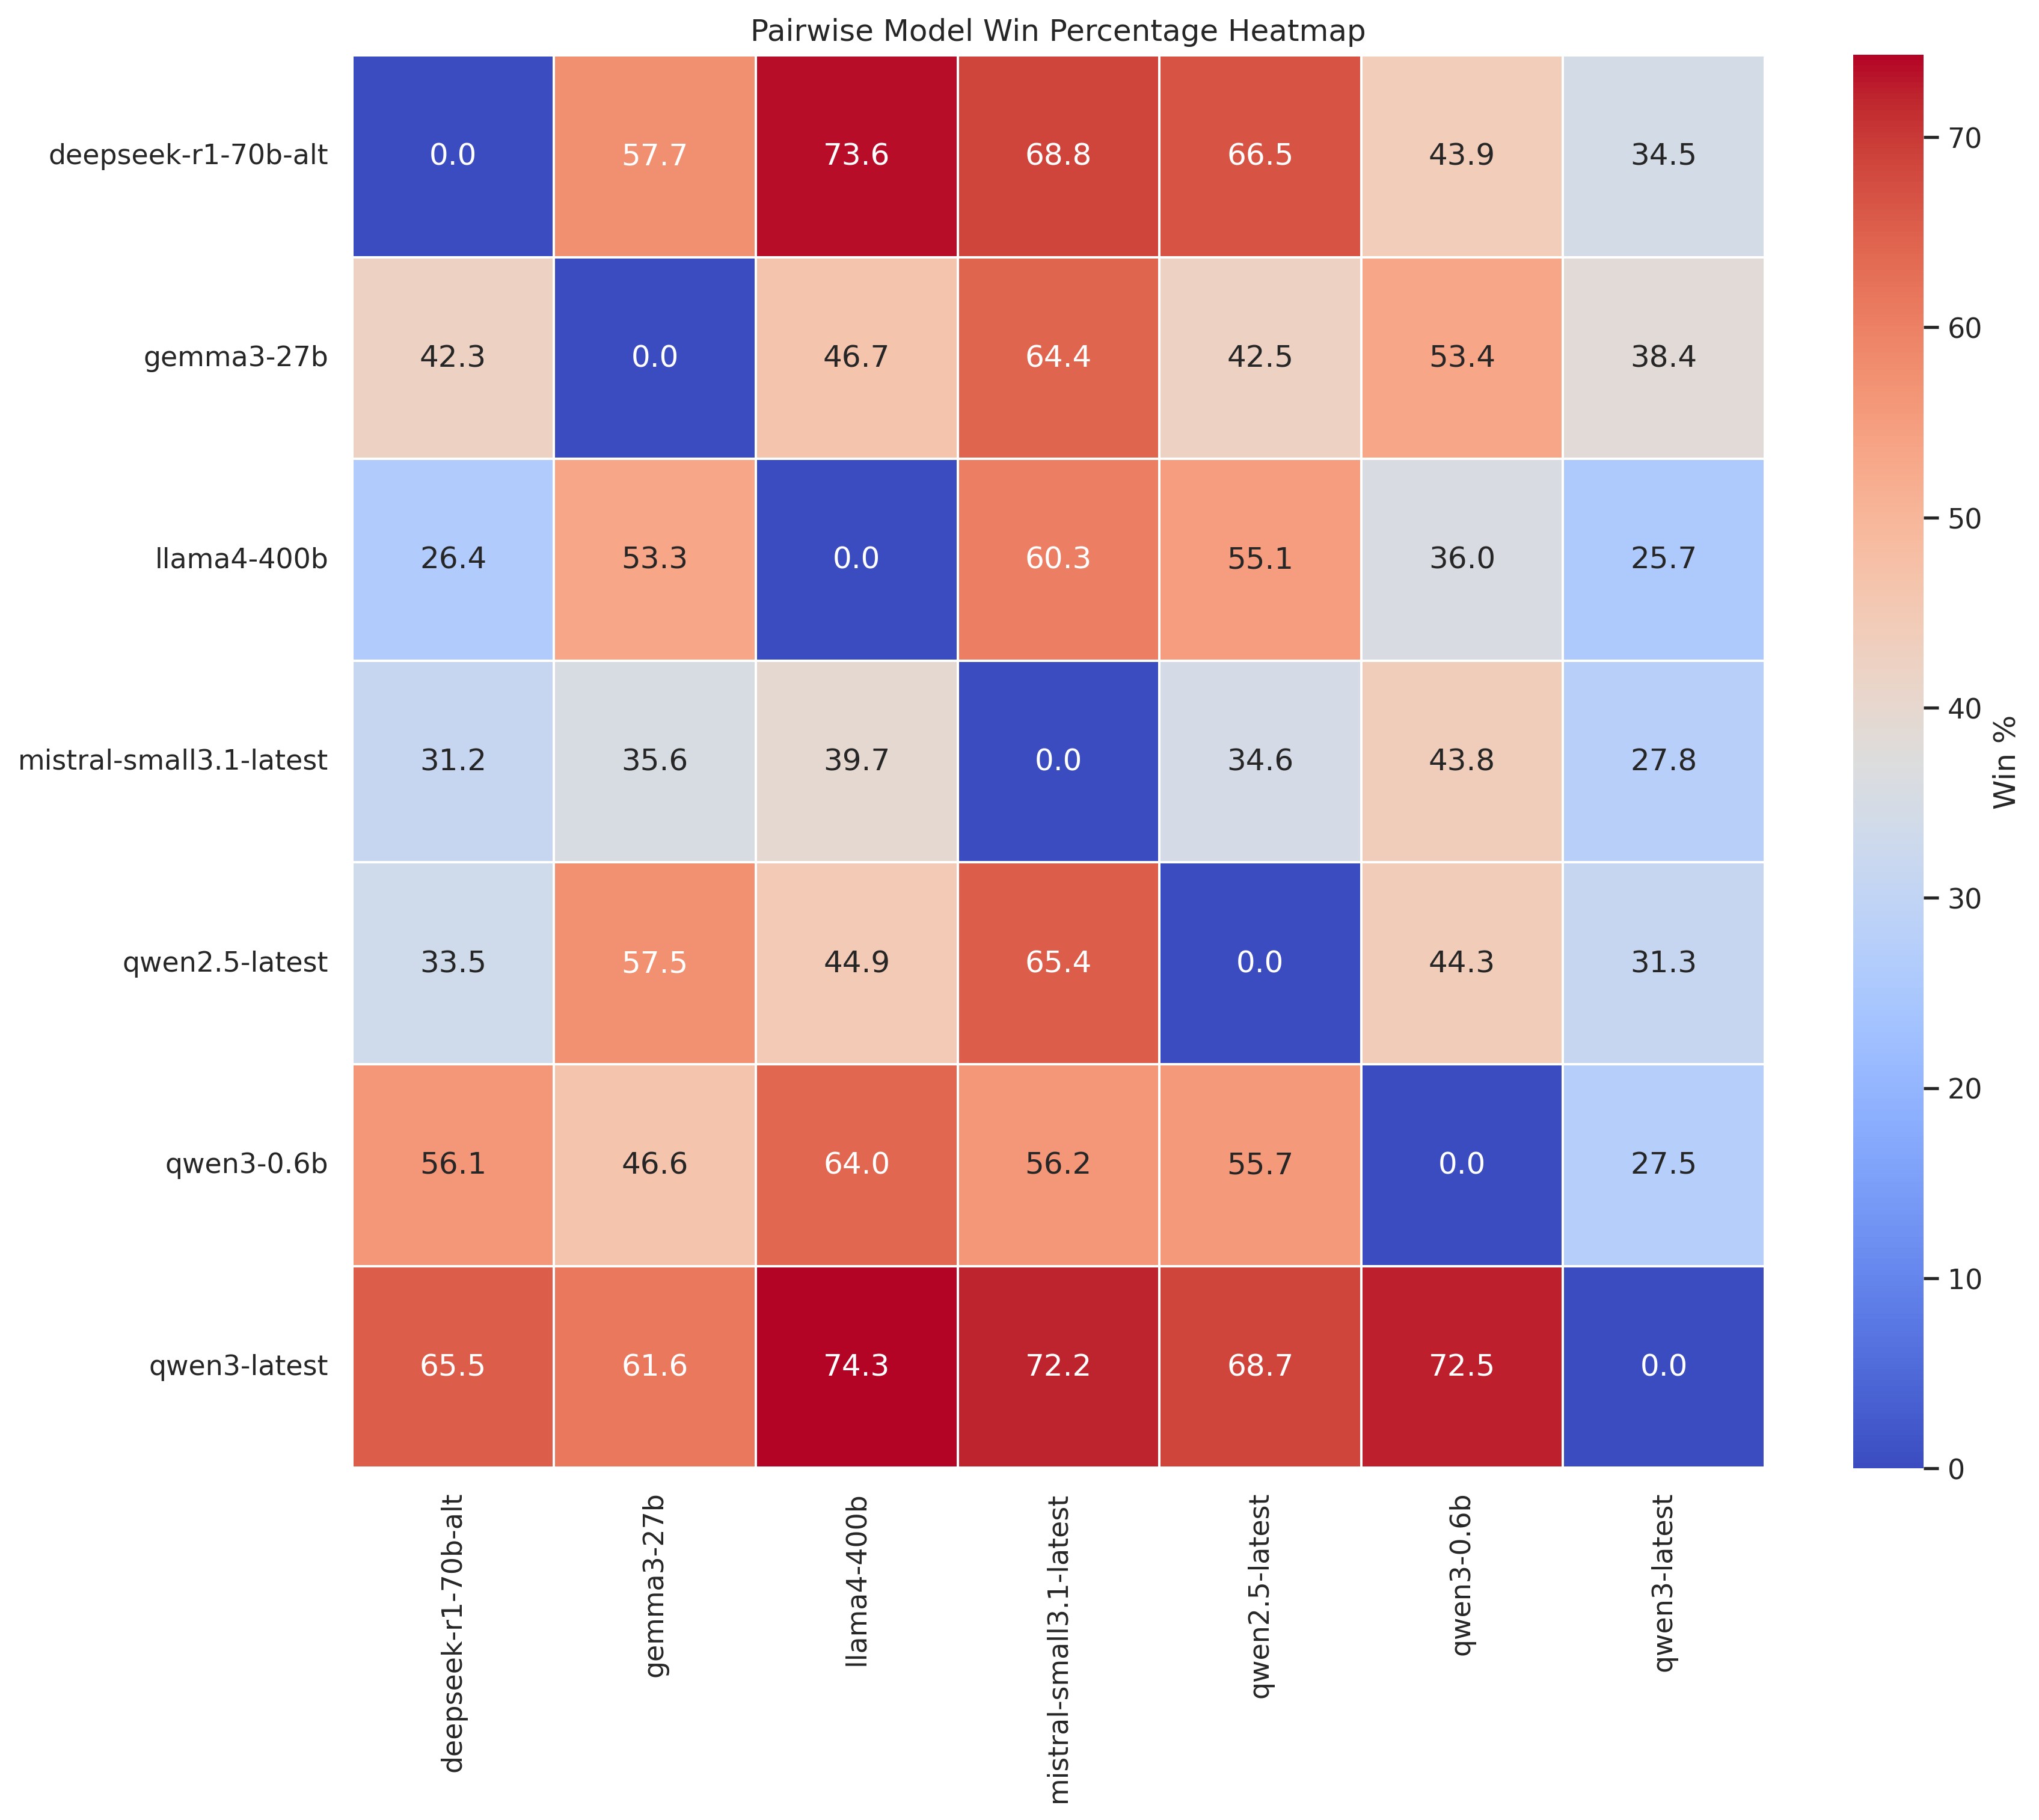

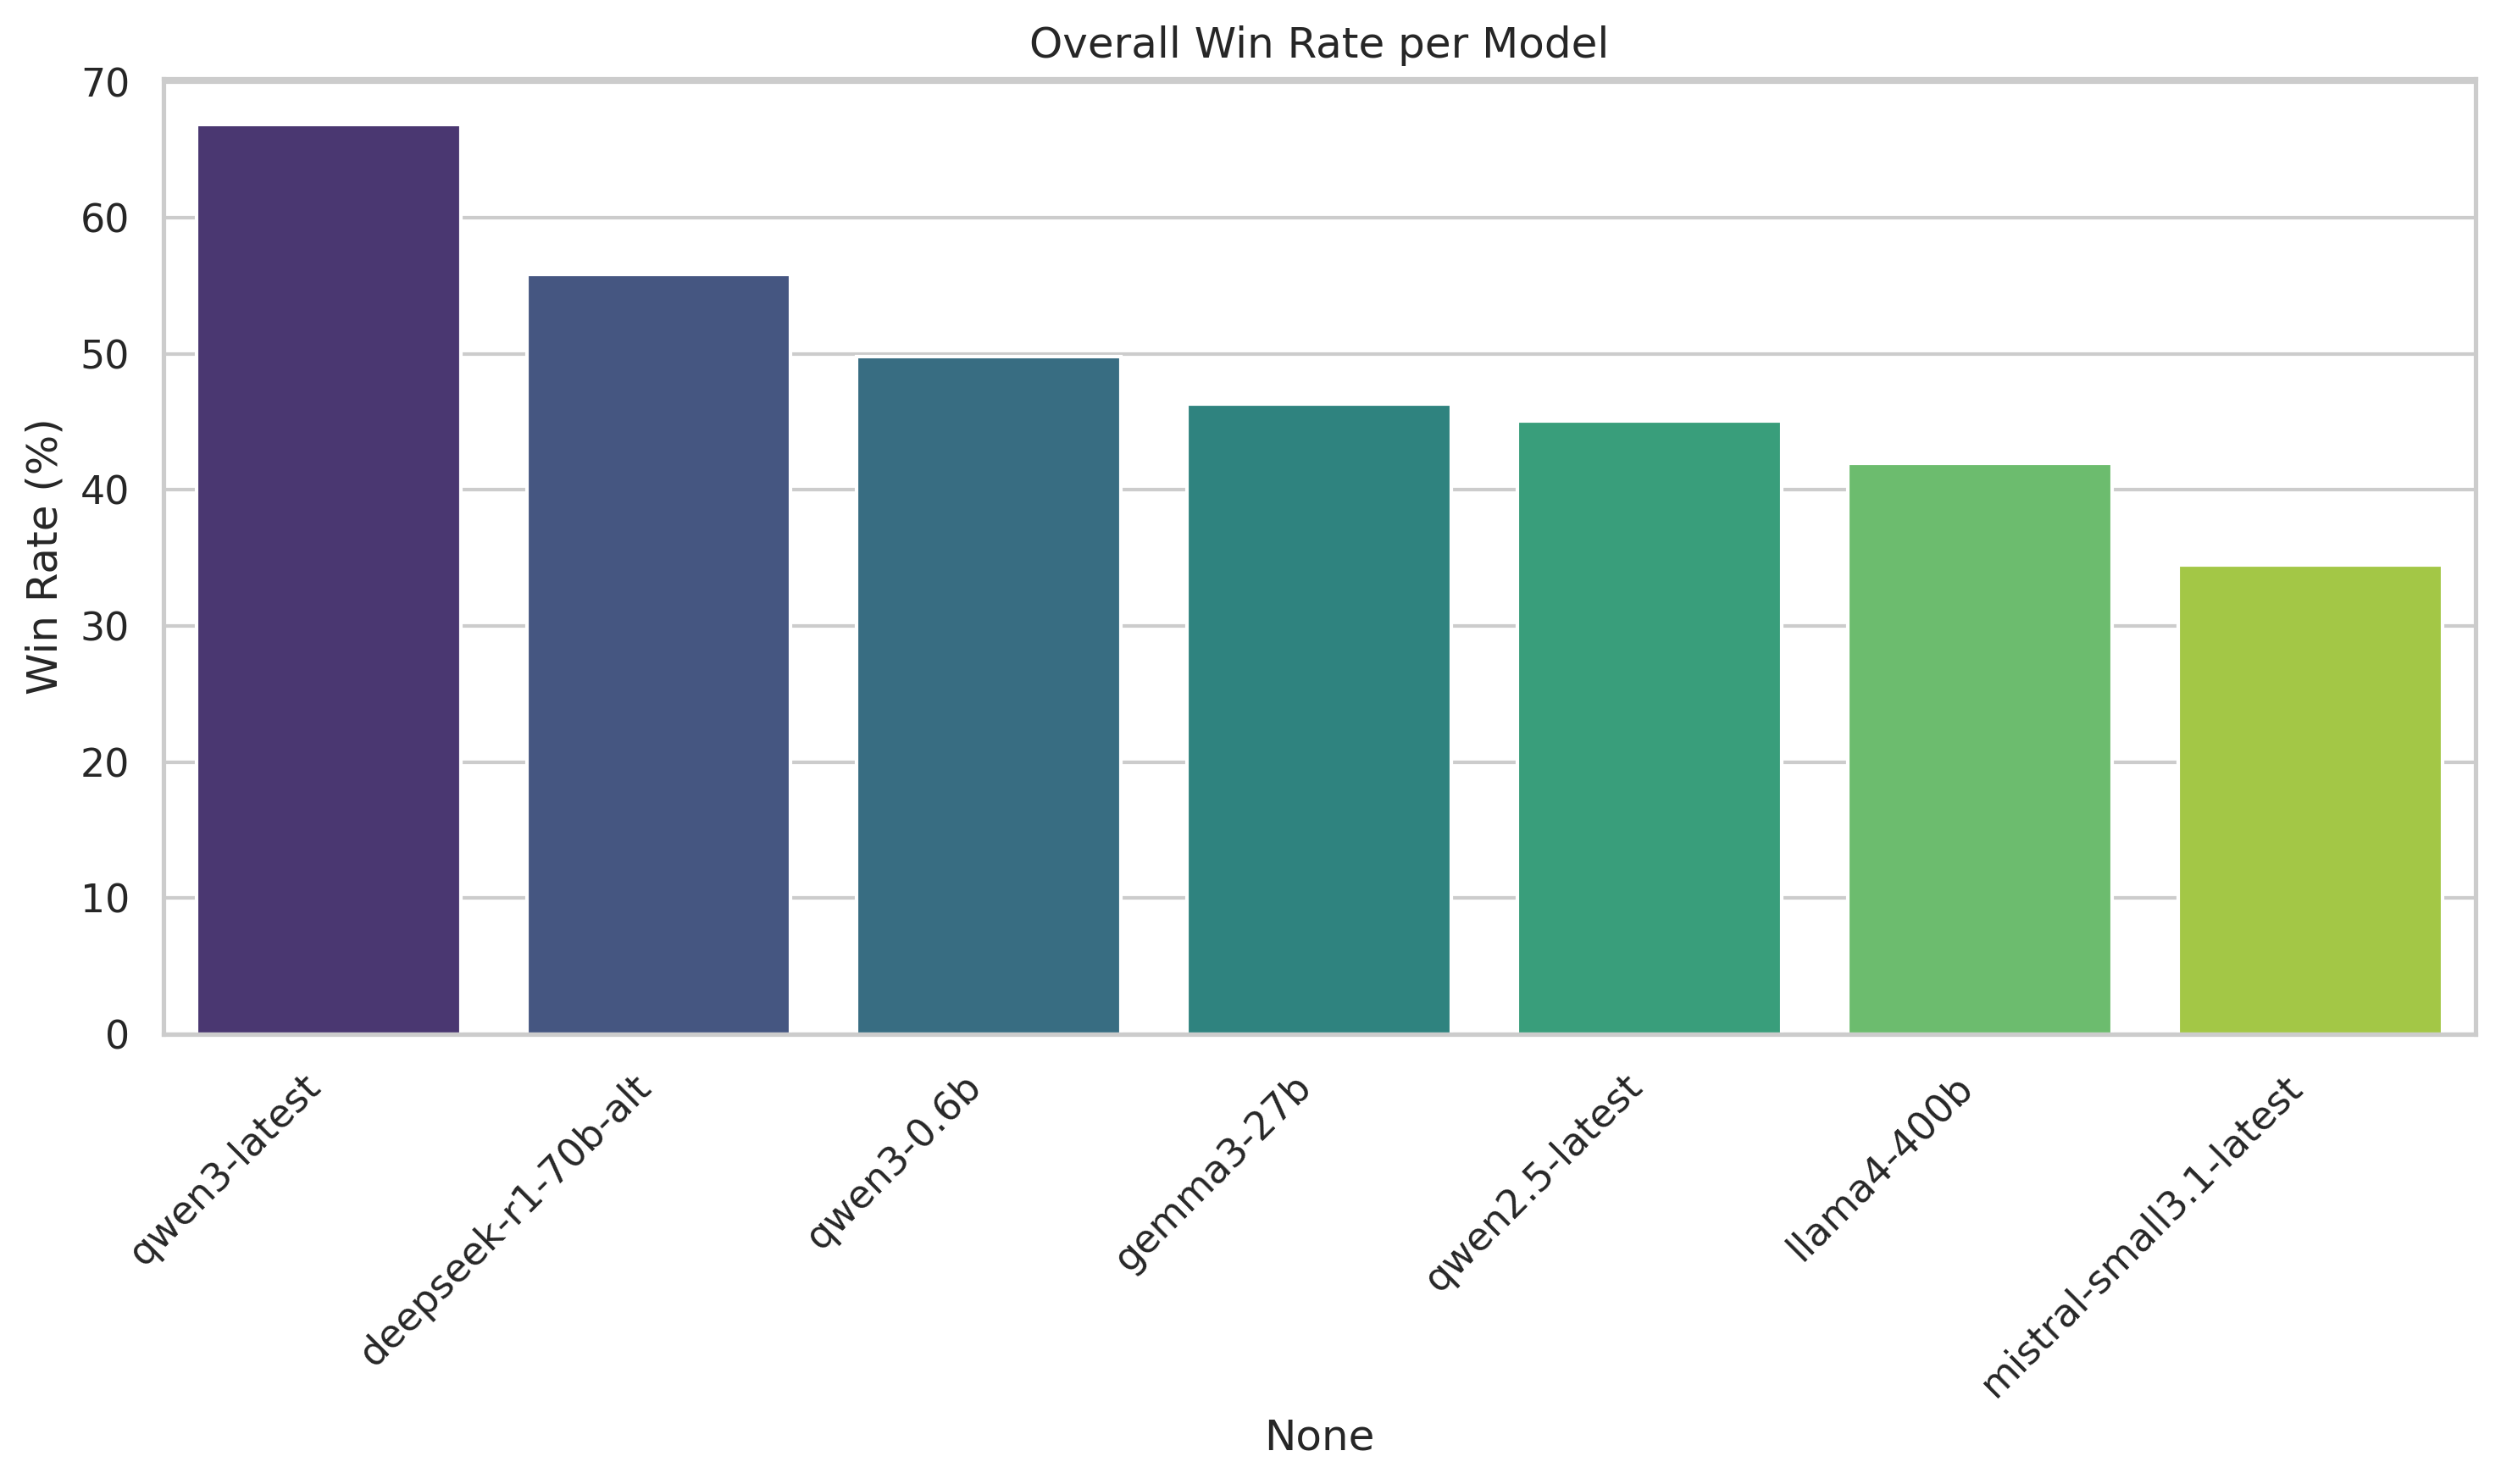

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind
import glob

# Setup for high-res plots
plt.rcParams["figure.dpi"] = 300
sns.set(style="whitegrid")

# Get unique model names
models = sorted(set(all_results['model_a']).union(set(all_results['model_b'])))

# Create win matrix
win_matrix = pd.DataFrame(0, index=models, columns=models)
for _, row in all_results.iterrows():
    verdict = row['verdict']
    a, b = row['model_a'], row['model_b']
    if verdict == "A":
        win_matrix.loc[a, b] += 1
    elif verdict == "B":
        win_matrix.loc[b, a] += 1

# Compute win percentages
total_matches = win_matrix + win_matrix.T
win_percent = (win_matrix.div(total_matches.where(total_matches > 0), axis=1) * 100).fillna(0)

# Summary of wins, losses, ties
summary = {}
for model in models:
    wins = ((all_results['verdict'] == "A") & (all_results['model_a'] == model)).sum()
    wins += ((all_results['verdict'] == "B") & (all_results['model_b'] == model)).sum()
    losses = ((all_results['verdict'] == "B") & (all_results['model_a'] == model)).sum()
    losses += ((all_results['verdict'] == "A") & (all_results['model_b'] == model)).sum()
    ties = ((all_results['verdict'] == "Tie") & ((all_results['model_a'] == model) | (all_results['model_b'] == model))).sum()
    summary[model] = {
        "wins": wins,
        "losses": losses,
        "ties": ties,
        "total": wins + losses + ties,
        "win_rate": round(100 * wins / (wins + losses + ties), 2) if (wins + losses + ties) > 0 else 0.0
    }

# Create summary DataFrame
summary_df = pd.DataFrame.from_dict(summary, orient="index").sort_values(by="win_rate", ascending=False)

# Save summary table
summary_df.to_csv("model_comparison_summary.csv")

# Plot heatmap of win percentages
plt.figure(figsize=(12, 10))
sns.heatmap(win_percent, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5, square=True, cbar_kws={'label': 'Win %'})
plt.title("Pairwise Model Win Percentage Heatmap")
plt.tight_layout()
plt.savefig("win_percentage_heatmap.png", dpi=300)

# Plot bar chart of win rates
plt.figure(figsize=(10, 6))
sns.barplot(x=summary_df.index, y="win_rate", data=summary_df, palette="viridis")
plt.ylabel("Win Rate (%)")
plt.xticks(rotation=45, ha="right")
plt.title("Overall Win Rate per Model")
plt.tight_layout()
plt.savefig("win_rate_barplot.png", dpi=300)

# Display results
import ace_tools as tools; tools.display_dataframe_to_user(name="Model Comparison Summary", dataframe=summary_df)


In [12]:
import os
import pandas as pd
from collections import defaultdict

# Path where your CSVs are stored
data_folder = "./"  # Change this to your actual path if needed
summary = defaultdict(lambda: {"wins": 0, "losses": 0, "ties": 0})

# Scan all CSV files
for file in os.listdir(data_folder):
    if file.endswith(".csv") and "_vs_" in file:
        df = pd.read_csv(os.path.join(data_folder, file))
        for _, row in df.iterrows():
            a = row["model_a"]
            b = row["model_b"]
            v = row["verdict"]

            if v == "A":
                summary[a]["wins"] += 1
                summary[b]["losses"] += 1
            elif v == "B":
                summary[b]["wins"] += 1
                summary[a]["losses"] += 1
            elif v == "Tie":
                summary[a]["ties"] += 1
                summary[b]["ties"] += 1

summary_df = pd.DataFrame(summary).T
summary_df = summary_df.sort_values(by="wins", ascending=False)
summary_df.to_csv("model_comparison_summary.csv")
summary_df


,wins,losses,ties
qwen3-latest,2456,1094,122
deepseek-r1-70b-alt,2050,1506,116
qwen3-0.6b,1828,1756,88
gemma3-27b,1700,1841,131
qwen2.5-latest,1655,1935,82
llama4-400b,1540,2058,74
mistral-small3.1-latest,1266,2305,101


<Figure size 3600x1800 with 0 Axes>

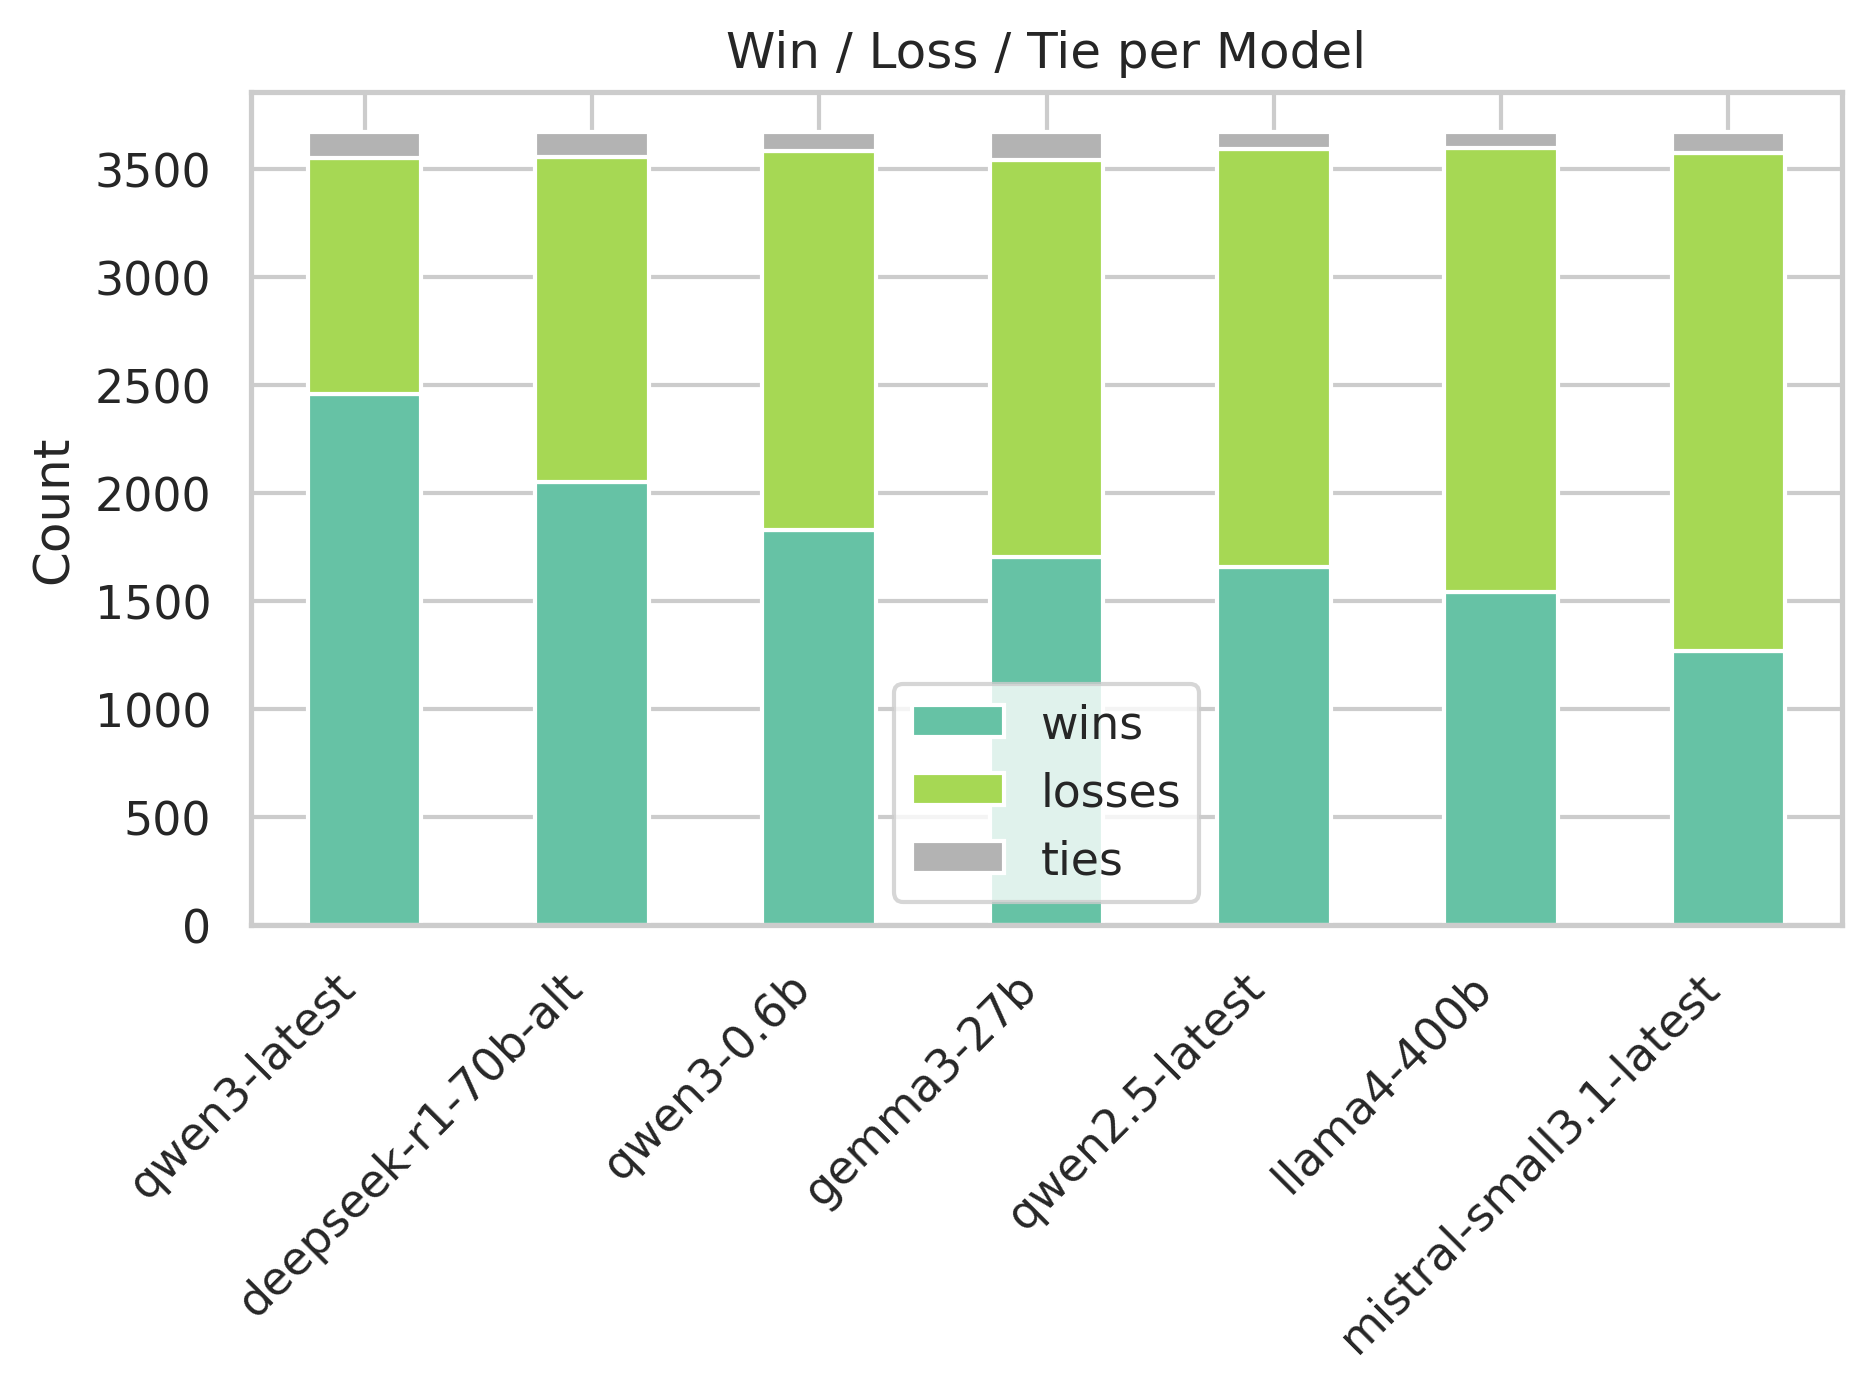

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
summary_df[["wins", "losses", "ties"]].plot(kind='bar', stacked=True, colormap='Set2')
plt.ylabel("Count")
plt.title("Win / Loss / Tie per Model")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("win_loss_tie_stacked_bar.png", dpi=300)
plt.show()


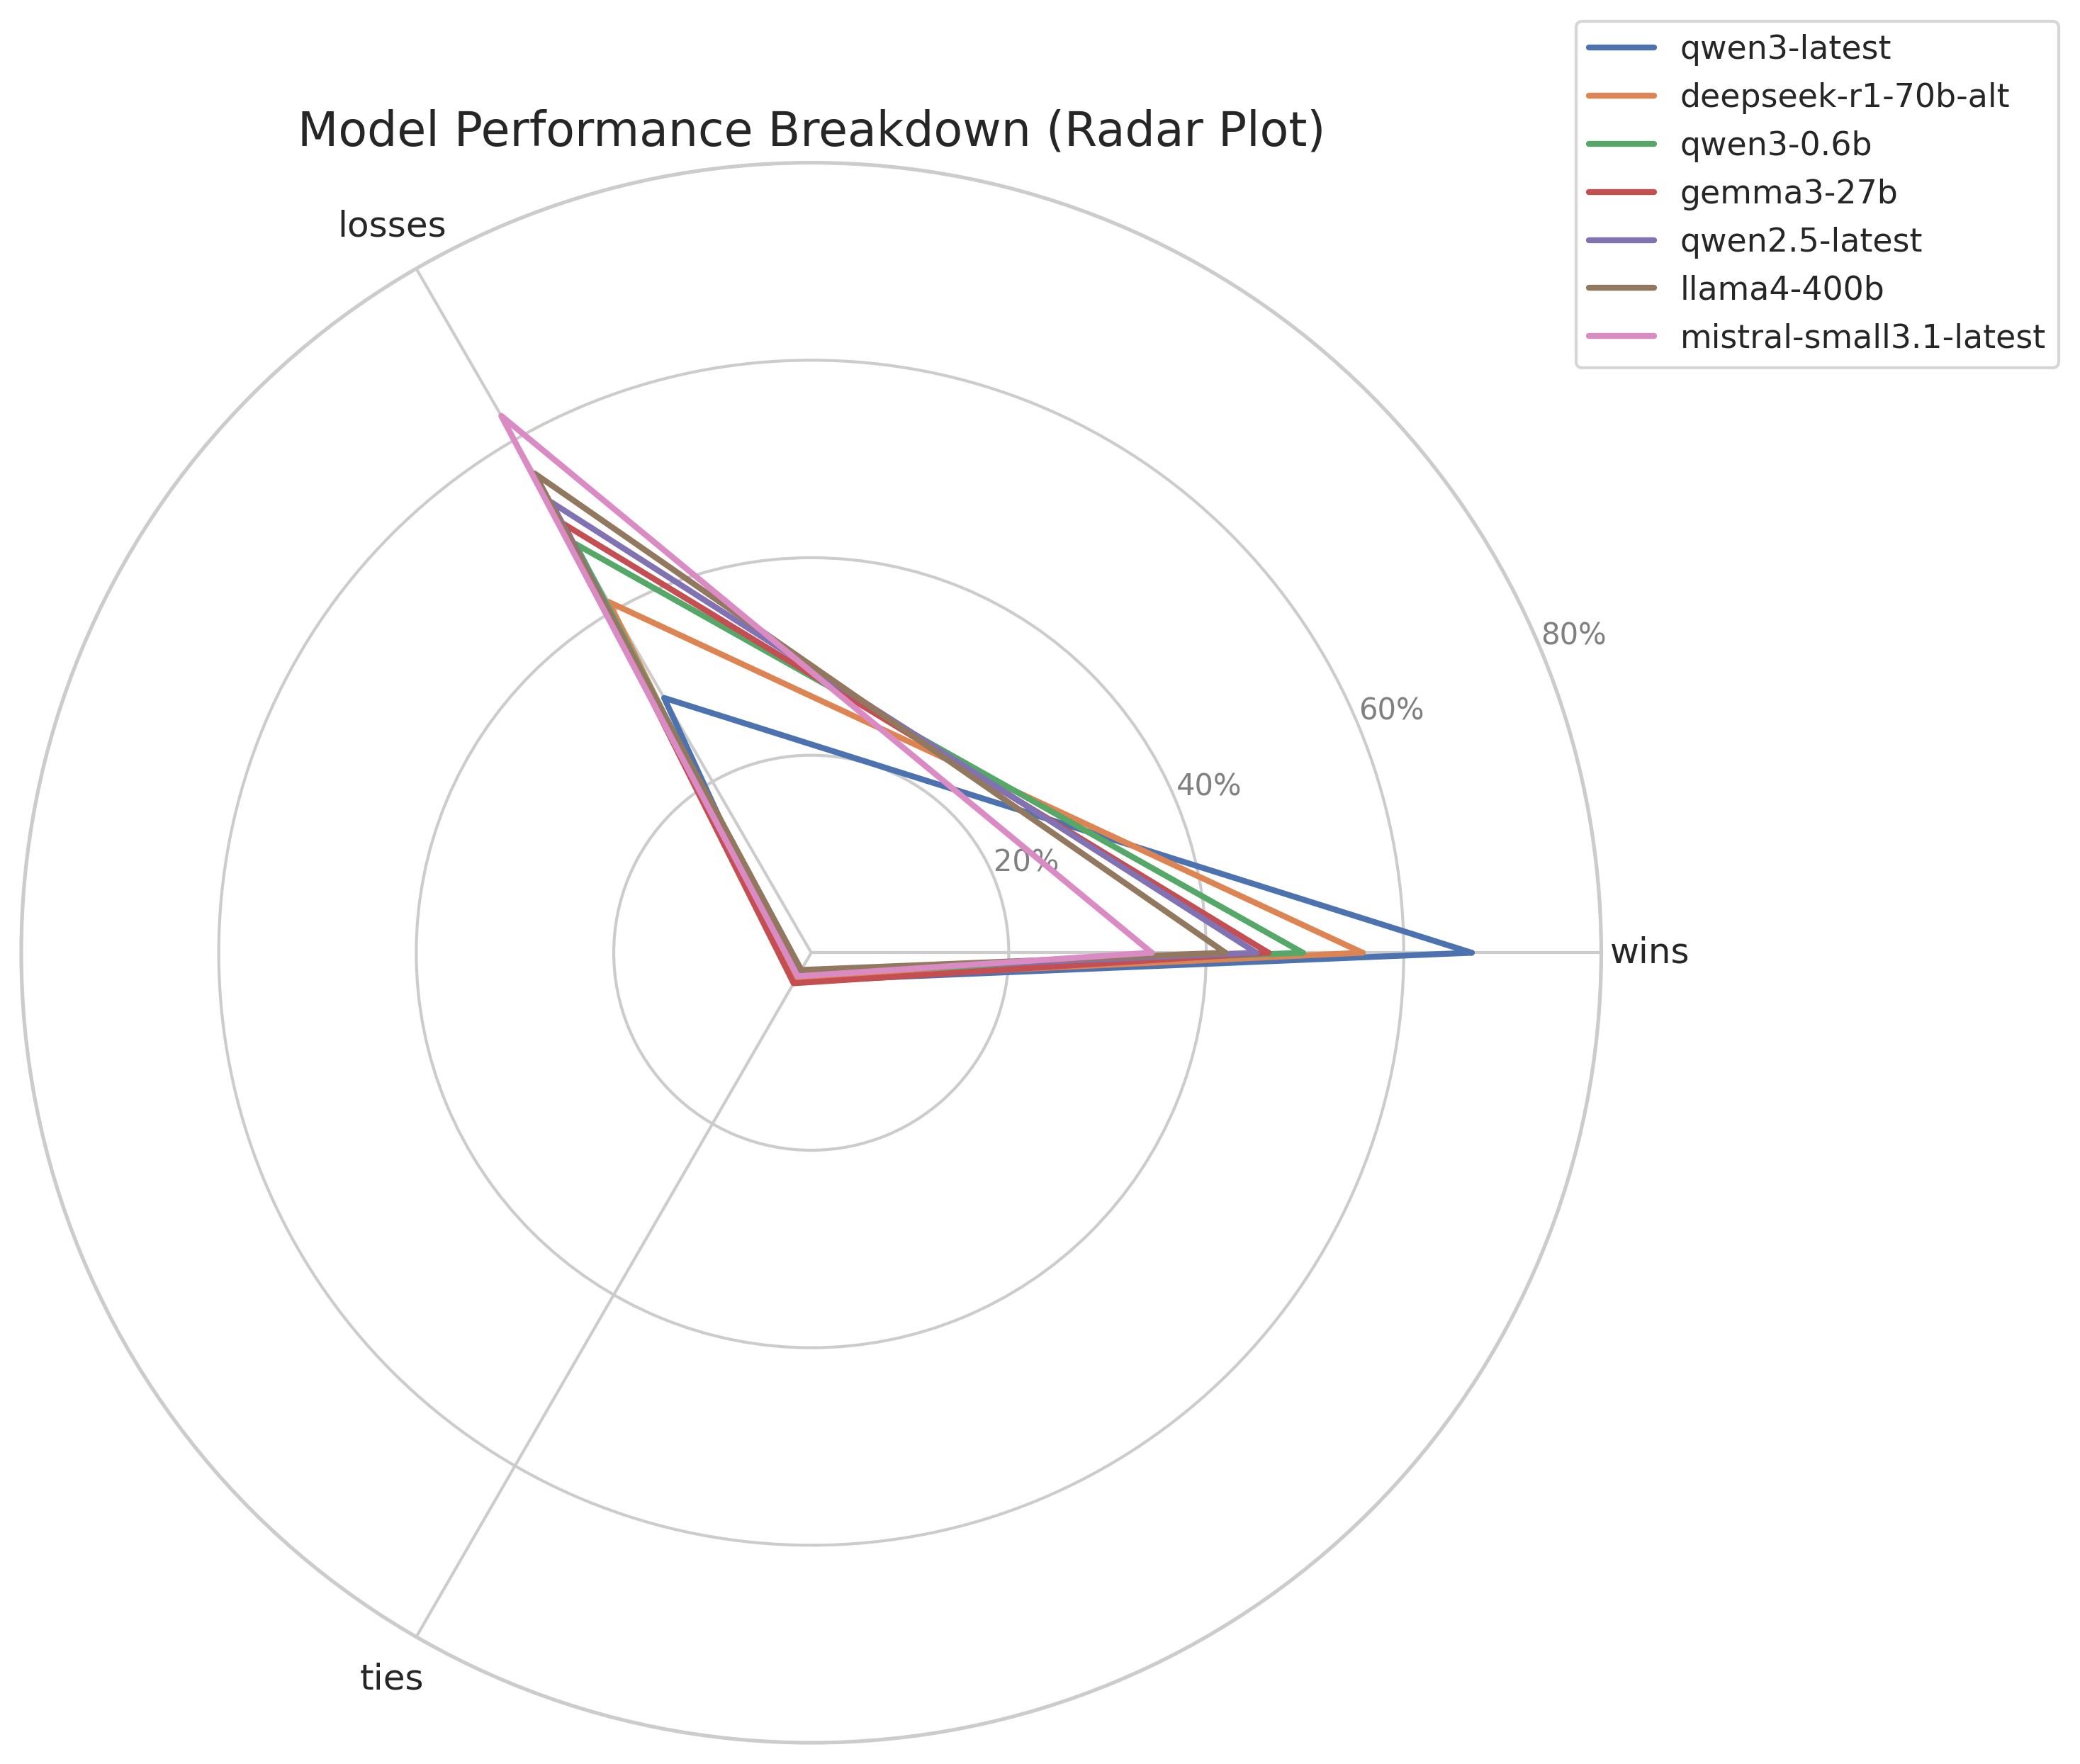

In [14]:
import numpy as np

# Radar Plot
categories = ['wins', 'losses', 'ties']
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(10, 10))

for model in summary_df.index:
    values = summary_df.loc[model, categories].values
    total = values.sum()
    values = [v / total for v in values] if total > 0 else [0, 0, 0]
    values += values[:1]
    plt.polar(angles, values, label=model, linewidth=2)

plt.xticks(angles[:-1], categories, fontsize=12)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["20%", "40%", "60%", "80%"], color="grey", size=10)
plt.title("Model Performance Breakdown (Radar Plot)", size=16)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig("model_performance_radar_plot.png", dpi=300)
plt.show()


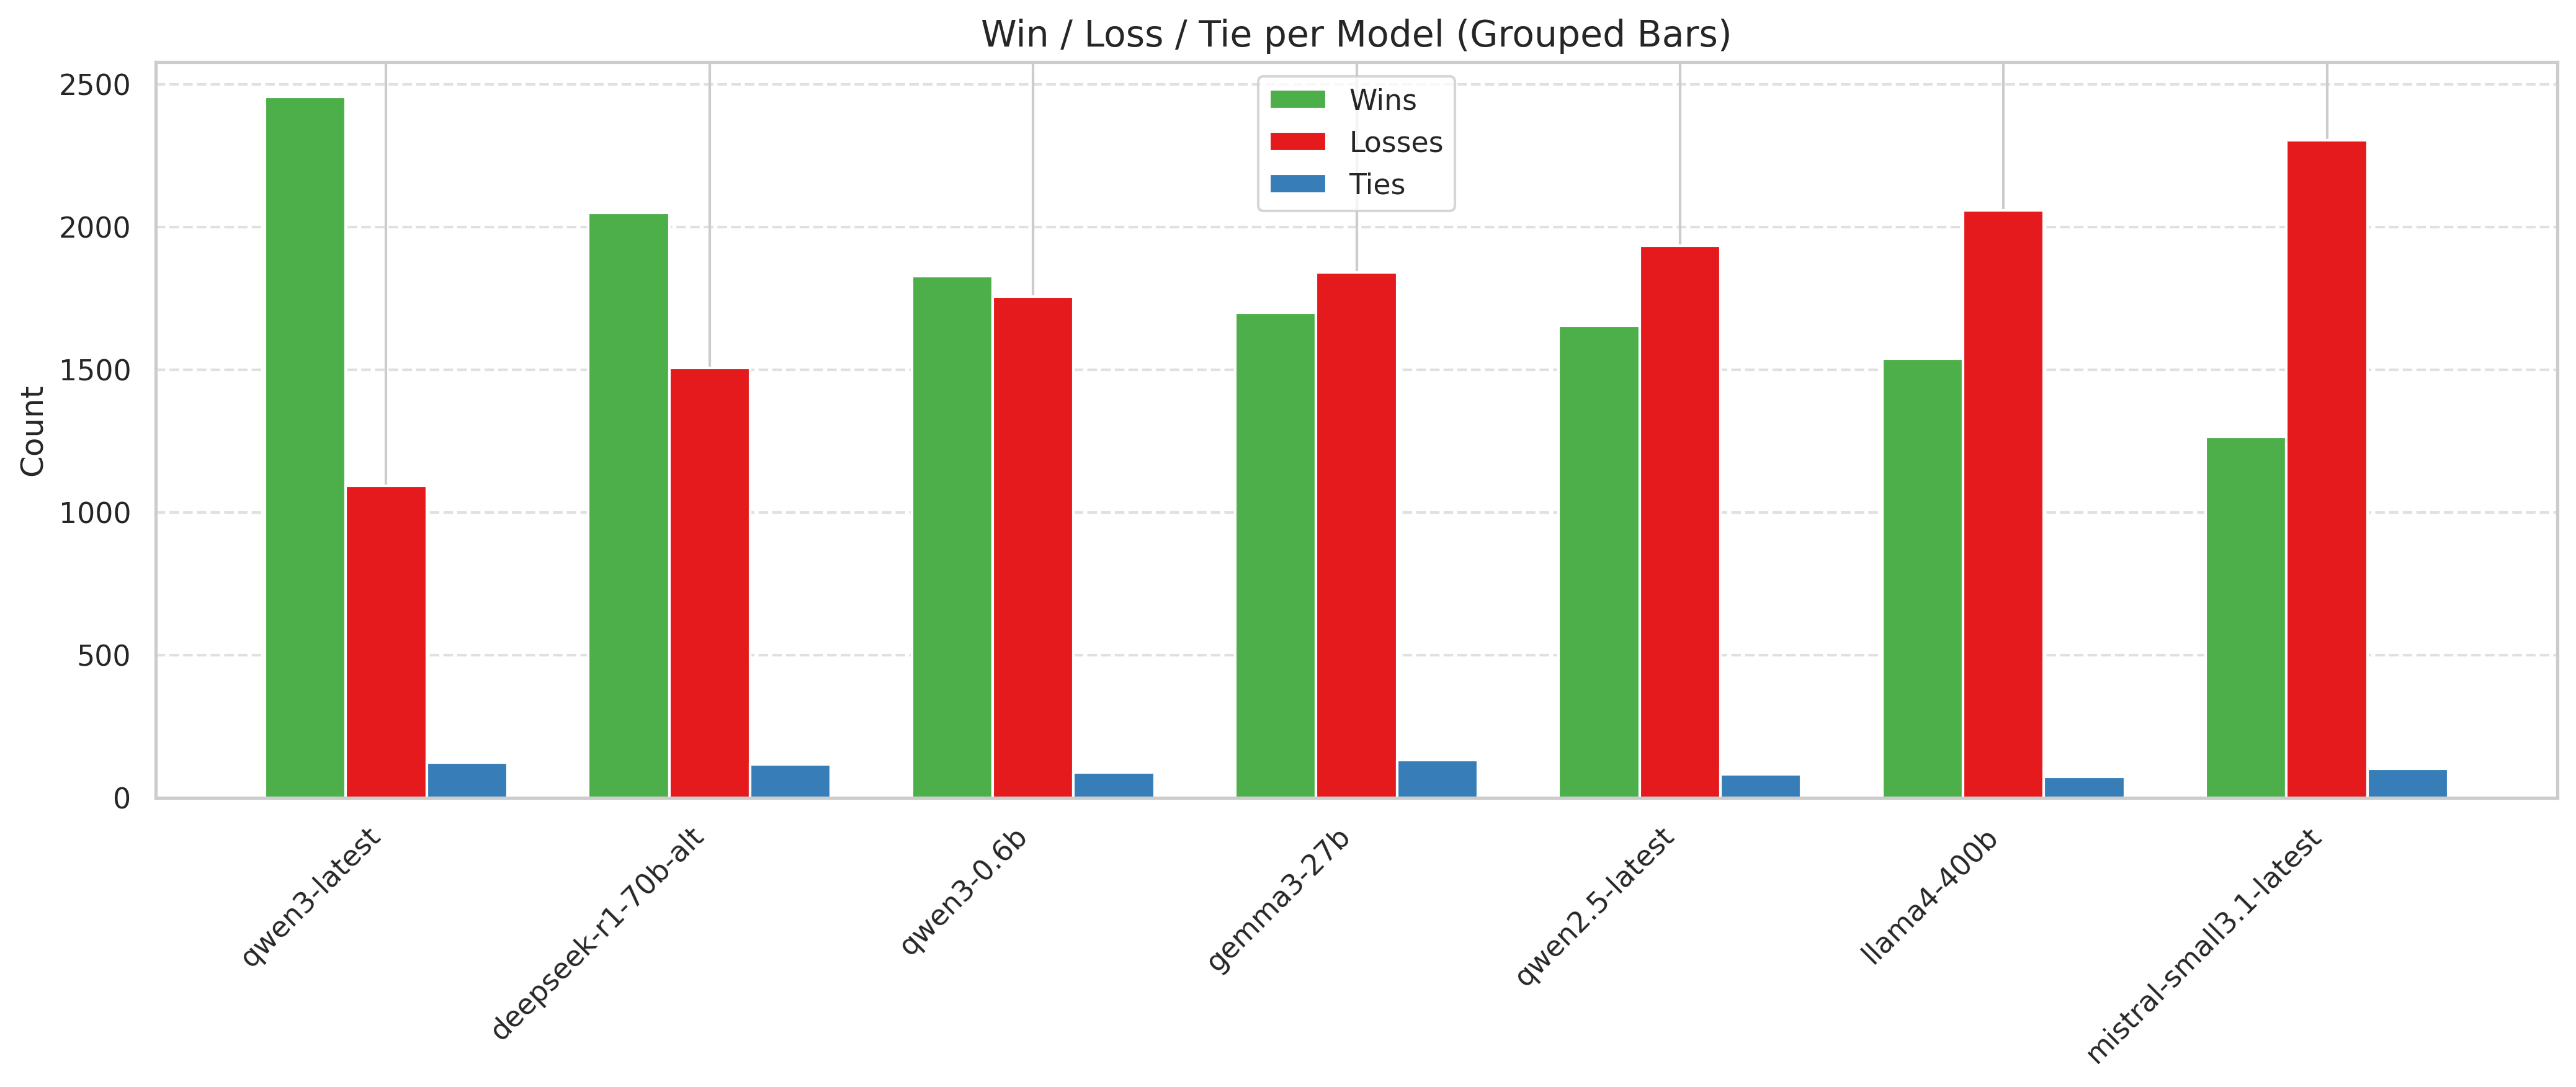

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Data
data = summary_df[["wins", "losses", "ties"]]
models = summary_df.index.tolist()
x = np.arange(len(models))  # label locations
width = 0.25  # width of each bar

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
bar1 = ax.bar(x - width, data["wins"], width, label='Wins', color='#4daf4a')
bar2 = ax.bar(x, data["losses"], width, label='Losses', color='#e41a1c')
bar3 = ax.bar(x + width, data["ties"], width, label='Ties', color='#377eb8')

# Labels and titles
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Win / Loss / Tie per Model (Grouped Bars)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("win_loss_tie_grouped_bar.png", dpi=300)
plt.show()
